In [68]:
import pandas as pd
import numpy as np
# from pandas_profiling import ProfileReport
from ydata_profiling import ProfileReport
import datetime
import plotly
import plotly.offline as pyoff
import plotly.graph_objs as go
from plotly.subplots import make_subplots
%matplotlib inline
import seaborn as sns
sns.set()
from prophet import Prophet
from prophet.serialize import model_to_json, model_from_json
from joblib import dump, load
from prophet.serialize import model_to_json, model_from_json
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

from mlforecast import MLForecast
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean
import logging
#logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

## Les fonctions à utiliser 

### draw_ts_multiple

In [69]:
def draw_ts_multiple(df: pd.DataFrame, v1: str, v2: str=None, prediction: str=None, date: str='date',
              secondary_y=True, covid_zone=False, display=True):
  """Draw times series possibly on two y axis, with COVID period option.

  Args:
  - df (pd.DataFrame): time series dataframe (one line per date, series in columns)
  - v1 (str | list[str]): name or list of names of the series to plot on the first x axis
  - v2 (str): name of the serie to plot on the second y axis (default: None)
  - prediction (str): name of v1 hat (prediction) displayed with a dotted line (default: None)
  - date (str): name of date column for time (default: 'date')
  - secondary_y (bool): use a secondary y axis if v2 is used (default: True)
  - covid_zone (bool): highlight COVID-19 period with a grayed rectangle (default: False)
  - display (bool): display figure otherwise just return the figure (default: True)

  Returns:
  - fig (plotly.graph_objs._figure.Figure): Plotly figure generated

  Notes:
  Make sure to use the semi-colon trick if you don't want to have the figure displayed twice.
  Or use `display=False`.
  """
  if isinstance(v1, str):
    variables = [(v1, 'V1')]
  else:
    variables = [(v, 'V1.{}'.format(i)) for i, v in enumerate(v1)]
  title = '<br>'.join([n + ': '+ v for v, n in variables]) + ('<br>V2: ' + v2) if v2 else '<br>'.join([v + ': '+ n for v, n in variables])
  layout = dict(
    title=title,
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
  )
  fig = make_subplots(specs=[[{"secondary_y": True}]])
  fig.update_layout(layout)
  for v, name in variables:
    fig.add_trace(go.Scatter(x=df[date], y=df[v], name=name), secondary_y=False)
  if v2:
    fig.add_trace(go.Scatter(x=df[date], y=df[v2], name='V2'), secondary_y=secondary_y)
    fig['layout']['yaxis2']['showgrid'] = False
    fig.update_yaxes(rangemode='tozero')
    fig.update_layout(margin=dict(t=125 + 30 * (len(variables) - 1)))
  if prediction:
    fig.add_trace(go.Scatter(x=df[date], y=df[prediction], name='^V1', line={'dash': 'dot'}), secondary_y=False)

  if covid_zone:
    fig.add_vrect(
        x0=pd.Timestamp("2020-03-01"), x1=pd.Timestamp("2022-01-01"),
        fillcolor="Gray", opacity=0.5,
        layer="below", line_width=0,
    )
  if display:
    pyoff.iplot(fig)
  return fig

### generate_route_df

In [70]:
def generate_route_df(traffic_df: pd.DataFrame, homeAirport:str, paireAirport: str) -> pd.DataFrame:
    

    # """
    # Extract route datafrae from traffic dataframe for route from home airport to paired airport 
    # Args:
    # -traffic_df (pd.DataFrame): traffic datafram
    # - homeAirport (str): IAIA code from airport
    # - pairedAirport (str): IAIA coe for paired airpport
    # Return
    # """

    _df=(traffic_df
        .query ('home_airport == "{}" and paired_airport =="{}"'.format(homeAirport, paireAirport))
        .groupby(['home_airport', 'paired_airport', 'date'])
        .agg(pax_total=('pax', 'sum'))
        .reset_index() 
        )
    return _df

## Importer des données 

In [3]:
traffic_df = pd.read_parquet("/Users/lilyhuong/Desktop/Amse mag3/semestre 2/Forecast air traffic/airtraffic/traffic_10lines.parquet")

In [4]:
traffic_df.shape

(254899, 21)

## Descritive statistics 

### Par utiliser describe()

In [49]:
traffic_df.describe(include = 'all', datetime_is_numeric=True).transpose()

count unique        top    freq  \
date                  254899    NaN        NaN     NaN   
pax                 254899.0    NaN        NaN     NaN   
seats               250749.0    NaN        NaN     NaN   
flight_type           251168     19          J  240627   
flight_typename       254899      4  Scheduled  251250   
home_airport          254899      8        LIS  125254   
paired_airport        254899     10        OPO   72331   
home_airportname      254899      8     Lisbon  125254   
paired_airportname    254899     10      Porto   72331   
distance            254899.0   <NA>       <NA>    <NA>   
flight_number         251438   2663     TP 433    2332   
airline_iata          248648     90         TP   91648   
airline_name          254813    131        TAP   91648   
scheduled_datetime    254899    NaN        NaN     NaN   
direction             254899      2          D  127622   
home_country          254899      7         PT  125254   
paired_country        254899      8         PT   72331   
home_countryname      254899      7   Portugal  125254   
paired_countryname    254899      8   Portugal   72331   
travel_area           254899      4   Domestic  108770   
aircraft_type         251439    168       A320   30344   

                                             mean                  min  \
date                2019-04-14 00:20:15.163653120  2016-01-01 00:00:00   
pax                                    127.082676                -11.0   
seats                                  159.352879                  0.0   
flight_type                                   NaN                  NaN   
flight_typename                               NaN                  NaN   
home_airport                                  NaN                  NaN   
paired_airport                                NaN                  NaN   
home_airportname                              NaN                  NaN   
paired_airportname                            NaN                  NaN   
distance                               944.365078                277.0   
flight_number                                 NaN                  NaN   
airline_iata                                  NaN                  NaN   
airline_name                                  NaN                  NaN   
scheduled_datetime  2019-04-14 14:11:44.273065472  2016-01-01 06:10:00   
direction                                     NaN                  NaN   
home_country                                  NaN                  NaN   
paired_country                                NaN                  NaN   
home_countryname                              NaN                  NaN   
paired_countryname                            NaN                  NaN   
travel_area                                   NaN                  NaN   
aircraft_type                                 NaN                  NaN   

                                    25%                  50%  \
date                2017-07-31 00:00:00  2019-02-07 00:00:00   
pax                                88.0                140.0   
seats                             144.0                174.0   
flight_type                         NaN                  NaN   
flight_typename                     NaN                  NaN   
home_airport                        NaN                  NaN   
paired_airport                      NaN                  NaN   
home_airportname                    NaN                  NaN   
paired_airportname                  NaN                  NaN   
distance                          277.0               1109.0   
flight_number                       NaN                  NaN   
airline_iata                        NaN                  NaN   
airline_name                        NaN                  NaN   
scheduled_datetime  2017-07-31 06:55:00  2019-02-07 08:05:00   
direction                           NaN                  NaN   
home_country                        NaN                  NaN   
paired_country               

### Par utiliser ProfileReport()

In [67]:
profile_report = ProfileReport(traffic_df)
profile_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [62]:
# Enregistrer profilereport to html
profile_report.to_file("Analysis.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
# get the sum of total passsenger between home airport and pair airport
(traffic_df
.groupby(["home_airport", "paired_airport"])
.agg(date_min = ("date", "min"), date_max = ("date", "max"), pax = ("pax", "sum"))
.reset_index()
)

home_airport paired_airport   date_min   date_max        pax
0          LGW            AMS 2016-01-01 2023-03-09  5372822.0
1          LGW            BCN 2016-01-01 2023-03-10  7613076.0
2          LIS            OPO 2016-01-01 2023-03-09  5632745.0
3          LIS            ORY 2016-01-01 2023-03-09  7696068.0
4          LYS            PIS 2017-11-20 2023-03-09    10351.0
5          NTE            FUE 2019-01-06 2023-03-05    99854.0
6          PNH            NGB 2016-05-05 2023-03-07    10018.0
7          POP            JFK 2018-01-01 2023-03-09   492434.0
8          SCL            LHR 2019-01-01 2023-03-07   193693.0
9          SSA            GRU 2019-01-01 2023-03-09  5272186.0

In [11]:
#get the airline name with home airport and pair arport is NTE and FUE with minimum of 100 passengers 
(traffic_df
.query('home_airport == "NTE" and paired_airport == "FUE" and pax >= 100')
["airline_name"]
.value_counts()
)

Volotea                339
Smartwings             116
Transavia               90
Enter Air               77
ASL Airlines France      1
Name: airline_name, dtype: int64

In [12]:
(traffic_df
.query('home_airport == "NTE" and paired_airport == "FUE"')
["airline_name"]
.value_counts()
)

Volotea                362
Smartwings             140
Transavia               98
Enter Air               81
ASL Airlines France      1
Ryanair                  1
Name: airline_name, dtype: int64

### Plot le nombre total de passengers par jour entre NTE et FUE 

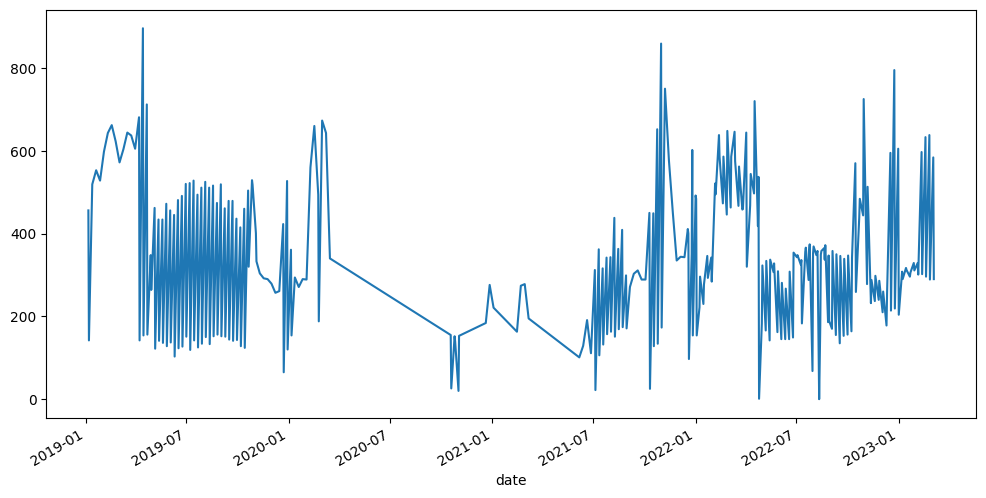

In [14]:

(traffic_df
.query('home_airport == "NTE" and paired_airport == "FUE"')
.groupby(["home_airport", "paired_airport", "date"])
.agg(pax_total = ("pax", "sum"))
.reset_index()
.set_index("date")
["pax_total"]
.plot(figsize= (12, 6))
);

In [65]:
# traffic_df.query('home_airport == "NTE" and paired_airport == "FUE"').groupby(["home_airport", "paired_airport", "date"]).agg(pax_total = ("pax", "sum")).reset_index().set_index("date")["pax_total"].plot(figsize= (12, 6))


### Plot le nombre total de passengers par jour entre LGW et AMS

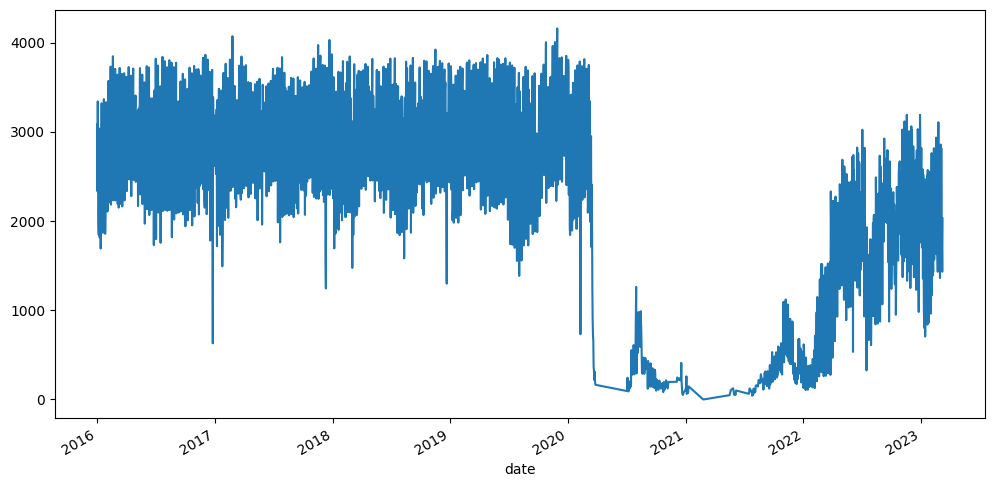

In [16]:

(traffic_df
.query('home_airport == "LGW" and paired_airport == "AMS"')
.groupby(["home_airport", "paired_airport", "date"])
.agg(pax_total = ("pax", "sum"))
.reset_index()
.set_index("date")
["pax_total"]
.plot(figsize= (12, 6))
);

In [66]:
# (traffic_df
# .query('home_airport == "LGW" and paired_airport == "AMS"')
# .groupby(["home_airport", "paired_airport", "date"])
# .agg(pax_total = ("pax", "sum"))
# .reset_index()
# .set_index("date")
# ["pax_total"]
# .plot(figsize= (12, 6))
# );

In [20]:
draw_ts_multiple(
    (traffic_df
    .query('home_airport == "LGW" and paired_airport == "AMS"')
    .groupby(["home_airport", "paired_airport", "date"])
    .agg(pax_total = ("pax", "sum"))
    .reset_index()
    ),
    'pax_total'
)

In [21]:
draw_ts_multiple(
    (traffic_df
    .query('home_airport == "LGW" and paired_airport == "AMS"')
    .groupby(["home_airport", "paired_airport", "date"])
    .agg(pax_total = ("pax", "sum"))
    .reset_index()
    ),
    'pax_total',
    covid_zone = True,
)

In [22]:

lgw_ams_df = (traffic_df
    .query('home_airport == "LGW" and paired_airport == "AMS"')
    .groupby(["home_airport", "paired_airport", "date"])
    .agg(pax_total = ("pax", "sum"))
    .reset_index()
    )
lgw_ams_df


home_airport paired_airport       date  pax_total
0             LGW            AMS 2016-01-01     3081.0
1             LGW            AMS 2016-01-02     2334.0
2             LGW            AMS 2016-01-03     3341.0
3             LGW            AMS 2016-01-04     2665.0
4             LGW            AMS 2016-01-05     1996.0
...           ...            ...        ...        ...
2243          LGW            AMS 2023-03-05     2815.0
2244          LGW            AMS 2023-03-06     1916.0
2245          LGW            AMS 2023-03-07     1741.0
2246          LGW            AMS 2023-03-08     1432.0
2247          LGW            AMS 2023-03-09     2029.0

[2248 rows x 4 columns]

## Prévision de trafic aérien 

In [24]:
nte_fue_df=(traffic_df
 .query ('home_airport == "NTE" and paired_airport =="FUE"')
 .groupby(['home_airport', 'paired_airport', 'date'])
 .agg(pax_total=('pax', 'sum'))
 .reset_index() 
 )
nte_fue_df



nte_ams_df=(traffic_df
 .query ('home_airport == "LGW" and paired_airport =="AMS"')
 .groupby(['home_airport', 'paired_airport', 'date'])
 .agg(pax_total=('pax', 'sum'))
 .reset_index() 
 )
nte_ams_df

home_airport paired_airport       date  pax_total
0             LGW            AMS 2016-01-01     3081.0
1             LGW            AMS 2016-01-02     2334.0
2             LGW            AMS 2016-01-03     3341.0
3             LGW            AMS 2016-01-04     2665.0
4             LGW            AMS 2016-01-05     1996.0
...           ...            ...        ...        ...
2243          LGW            AMS 2023-03-05     2815.0
2244          LGW            AMS 2023-03-06     1916.0
2245          LGW            AMS 2023-03-07     1741.0
2246          LGW            AMS 2023-03-08     1432.0
2247          LGW            AMS 2023-03-09     2029.0

[2248 rows x 4 columns]

### Prophet

In [25]:
baseline_model = Prophet()
baseline_model.fit(nte_fue_df.rename(columns = {'date':'ds', 'pax_total':'y'}))

18:29:51 - cmdstanpy - INFO - Chain [1] start processing
18:29:52 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
future_df = baseline_model.make_future_dataframe(periods=15) #prepare prediction for 15 days 

In [27]:
future_df.tail()

ds
303 2023-03-16
304 2023-03-17
305 2023-03-18
306 2023-03-19
307 2023-03-20

In [28]:
forecast_df = baseline_model.predict(future_df)

In [29]:
forecast_df  #yhat is the prediction

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2019-01-06  341.079424  298.651417  605.222893   341.079424   341.079424   
1   2019-01-07  340.949434   32.826294  331.373095   340.949434   340.949434   
2   2019-01-13  340.169493  232.448618  543.982186   340.169493   340.169493   
3   2019-01-20  339.259561  235.056460  546.354160   339.259561   339.259561   
4   2019-01-27  338.349630  286.319144  591.688677   338.349630   338.349630   
..         ...         ...         ...         ...          ...          ...   
303 2023-03-16  237.709910  -76.429890  229.088143   237.709910   237.709910   
304 2023-03-17  237.696720  268.405606  574.253165   237.696720   237.696720   
305 2023-03-18  237.683530  313.019467  628.212669   237.683530   237.683530   
306 2023-03-19  237.670340  356.030880  650.487225   237.670340   237.670340   
307 2023-03-20  237.657150   87.337122  388.918318   237.656934   237.657886   

     additive_terms  additive_terms_lower  additive_terms_upper      weekly  \
0        108.941493            108.941493            108.941493  132.840302   
1       -150.871118           -150.871118           -150.871118 -118.253191   
2         56.073219             56.073219             56.073219  132.840302   
3         51.009210             51.009210             51.009210  132.840302   
4        104.532296            104.532296            104.532296  132.840302   
..              ...                   ...                   ...         ...   
303     -163.904126           -163.904126           -163.904126 -288.799795   
304      183.184223            183.184223            183.184223   57.304080   
305      229.103327            229.103327            229.103327  102.300391   
306      260.524969            260.524969            260.524969  132.840302   
307       10.297225             10.297225             10.297225 -118.253191   

     weekly_lower  weekly_upper      yearly  yearly_lower  yearly_upper  \
0      132.840302    132.840302  -23.898808    -23.898808    -23.898808   
1     -118.253191   -118.253191  -32.617927    -32.617927    -32.617927   
2      132.840302    132.840302  -76.767083    -76.767083    -76.767083   
3      132.840302    132.840302  -81.831091    -81.831091    -81.831091   
4      132.840302    132.840302  -28.308006    -28.308006    -28.308006   
..            ...           ...         ...           ...           ...   
303   -288.799795   -288.799795  124.895669    124.895669    124.895669   
304     57.304080     57.304080  125.880143    125.880143    125.880143   
305    102.300391    102.300391  126.802936    126.802936    126.802936   
306    132.840302    132.840302  127.684667    127.684667    127.684667   
307   -118.253191   -118.253191  128.550417    128.550417    128.550417   

     multiplicative_terms  multiplicative_terms_lower  \
0                     0.0                         0.0   
1                     0.0                         0.0   
2                     0.0                         0.0   
3                     0.0                         0.0   
4                     0.0                         0.0   
..                    ...                         ...   
303                   0.0                         0.0   
304                   0.0                         0.0   
305                   0.0                         0.0   
306                   0.0                         0.0   
307                   0.0                         0.0   

     multiplicative_terms_upper        yhat  
0                           0.0  450.020917  
1                           0.0  190.078316  
2                           0.0  396.242712  
3                           0.0  390.268772  
4                           0.0  442.881925  
..                          ...         ...  
303                         0.0   73.805784  
304                         0.0  420.880943  
305                         0.0  466.786857  
306                         0.0  498.195309  
307       

In [30]:
#check compare the result 
nte_fue_df.query('date <= "2019-01-06"')

home_airport paired_airport       date  pax_total
0          NTE            FUE 2019-01-06      456.0

In [32]:
generate_route_df(traffic_df, 'LGW', "AMS")

home_airport paired_airport       date  pax_total
0             LGW            AMS 2016-01-01     3081.0
1             LGW            AMS 2016-01-02     2334.0
2             LGW            AMS 2016-01-03     3341.0
3             LGW            AMS 2016-01-04     2665.0
4             LGW            AMS 2016-01-05     1996.0
...           ...            ...        ...        ...
2243          LGW            AMS 2023-03-05     2815.0
2244          LGW            AMS 2023-03-06     1916.0
2245          LGW            AMS 2023-03-07     1741.0
2246          LGW            AMS 2023-03-08     1432.0
2247          LGW            AMS 2023-03-09     2029.0

[2248 rows x 4 columns]

In [33]:
baseline_model = Prophet()
baseline_model.fit(generate_route_df(traffic_df, 'NTE', "FUE").rename(columns = {'date':'ds', 'pax_total':'y'}))

18:29:53 - cmdstanpy - INFO - Chain [1] start processing
18:29:53 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
future_df = baseline_model.make_future_dataframe(periods=15) 
future_df

ds
0   2019-01-06
1   2019-01-07
2   2019-01-13
3   2019-01-20
4   2019-01-27
..         ...
303 2023-03-16
304 2023-03-17
305 2023-03-18
306 2023-03-19
307 2023-03-20

[308 rows x 1 columns]

In [35]:
forecast_df = baseline_model.predict(future_df)

In [36]:
forecast_df 

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2019-01-06  341.079424  298.541399  592.608164   341.079424   341.079424   
1   2019-01-07  340.949434   38.987435  333.436975   340.949434   340.949434   
2   2019-01-13  340.169493  247.876791  543.388571   340.169493   340.169493   
3   2019-01-20  339.259561  241.273027  542.922787   339.259561   339.259561   
4   2019-01-27  338.349630  301.264720  593.311367   338.349630   338.349630   
..         ...         ...         ...         ...          ...          ...   
303 2023-03-16  237.709910  -85.287389  226.284516   237.709910   237.709910   
304 2023-03-17  237.696720  266.260099  573.286009   237.696720   237.696720   
305 2023-03-18  237.683530  322.476984  624.240129   237.683530   237.683530   
306 2023-03-19  237.670340  339.782465  638.581252   237.670340   237.670340   
307 2023-03-20  237.657150  101.816587  409.504020   237.656311   237.658346   

     additive_terms  additive_terms_lower  additive_terms_upper      weekly  \
0        108.941493            108.941493            108.941493  132.840302   
1       -150.871118           -150.871118           -150.871118 -118.253191   
2         56.073219             56.073219             56.073219  132.840302   
3         51.009210             51.009210             51.009210  132.840302   
4        104.532296            104.532296            104.532296  132.840302   
..              ...                   ...                   ...         ...   
303     -163.904126           -163.904126           -163.904126 -288.799795   
304      183.184223            183.184223            183.184223   57.304080   
305      229.103327            229.103327            229.103327  102.300391   
306      260.524969            260.524969            260.524969  132.840302   
307       10.297225             10.297225             10.297225 -118.253191   

     weekly_lower  weekly_upper      yearly  yearly_lower  yearly_upper  \
0      132.840302    132.840302  -23.898808    -23.898808    -23.898808   
1     -118.253191   -118.253191  -32.617927    -32.617927    -32.617927   
2      132.840302    132.840302  -76.767083    -76.767083    -76.767083   
3      132.840302    132.840302  -81.831091    -81.831091    -81.831091   
4      132.840302    132.840302  -28.308006    -28.308006    -28.308006   
..            ...           ...         ...           ...           ...   
303   -288.799795   -288.799795  124.895669    124.895669    124.895669   
304     57.304080     57.304080  125.880143    125.880143    125.880143   
305    102.300391    102.300391  126.802936    126.802936    126.802936   
306    132.840302    132.840302  127.684667    127.684667    127.684667   
307   -118.253191   -118.253191  128.550417    128.550417    128.550417   

     multiplicative_terms  multiplicative_terms_lower  \
0                     0.0                         0.0   
1                     0.0                         0.0   
2                     0.0                         0.0   
3                     0.0                         0.0   
4                     0.0                         0.0   
..                    ...                         ...   
303                   0.0                         0.0   
304                   0.0                         0.0   
305                   0.0                         0.0   
306                   0.0                         0.0   
307                   0.0                         0.0   

     multiplicative_terms_upper        yhat  
0                           0.0  450.020917  
1                           0.0  190.078316  
2                           0.0  396.242712  
3                           0.0  390.268772  
4                           0.0  442.881925  
..                          ...         ...  
303                         0.0   73.805784  
304                         0.0  420.880943  
305                         0.0  466.786857  
306                         0.0  498.195309  
307       

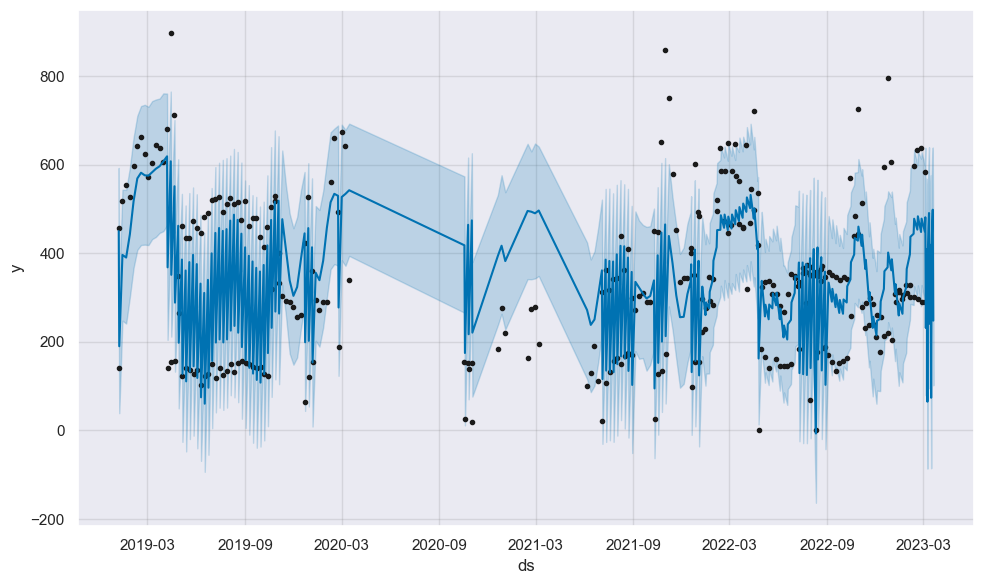

In [37]:
baseline_model.plot(forecast_df);
# graph = baseline_model.plot(forecast_df);

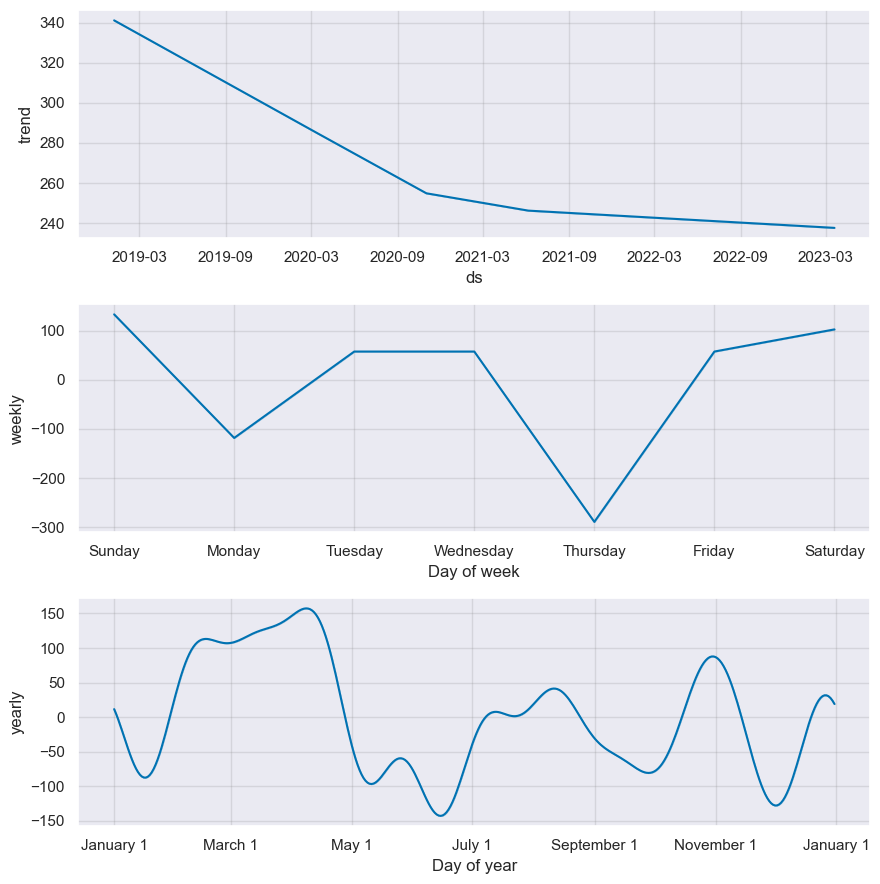

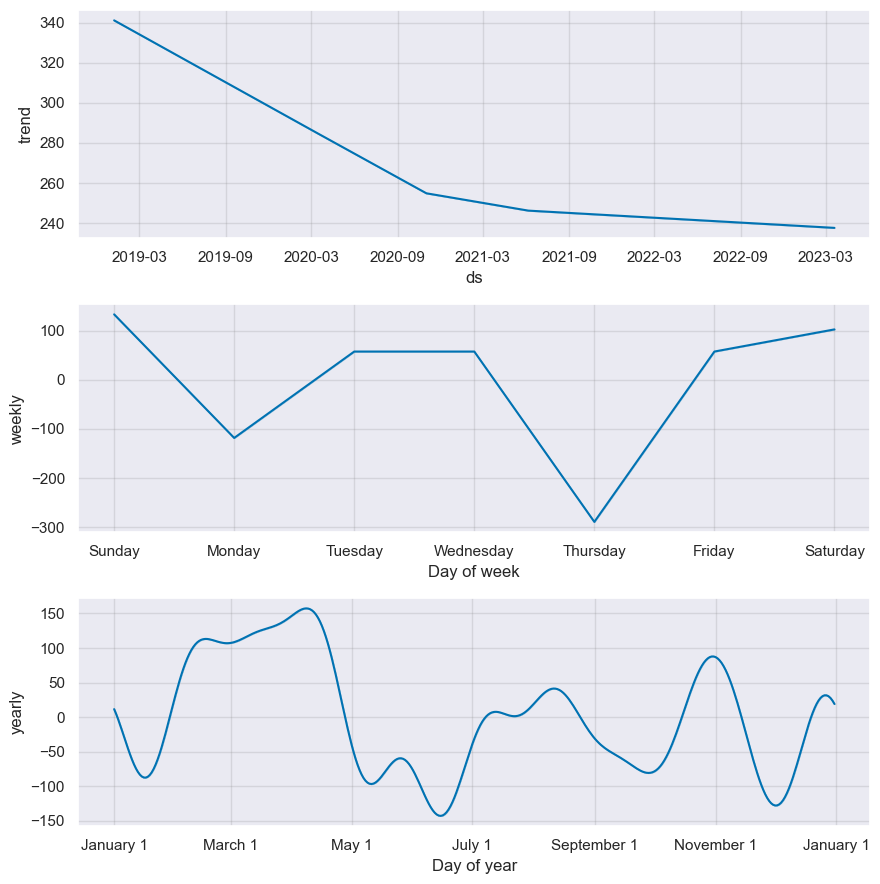

In [38]:
baseline_model.plot_components(forecast_df)

In [40]:
generate_route_df(traffic_df, 'NTE', 'FUE').date.count()

293

In [41]:
cross_validation(baseline_model, period = '3 M' , horizon= '3 M')

/opt/anaconda3/envs/airtraffic/lib/python3.9/site-packages/prophet/diagnostics.py:122: FutureWarning:

Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.

/opt/anaconda3/envs/airtraffic/lib/python3.9/site-packages/prophet/diagnostics.py:136: FutureWarning:

Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.



  0%|          | 0/205 [00:00<?, ?it/s]

18:29:55 - cmdstanpy - INFO - Chain [1] start processing
18:29:55 - cmdstanpy - INFO - Chain [1] done processing
18:29:55 - cmdstanpy - INFO - Chain [1] start processing
18:29:56 - cmdstanpy - INFO - Chain [1] done processing
18:29:56 - cmdstanpy - INFO - Chain [1] start processing
18:29:56 - cmdstanpy - INFO - Chain [1] done processing
18:29:56 - cmdstanpy - INFO - Chain [1] start processing
18:29:56 - cmdstanpy - INFO - Chain [1] done processing
18:29:56 - cmdstanpy - INFO - Chain [1] start processing
18:29:56 - cmdstanpy - INFO - Chain [1] done processing
18:29:56 - cmdstanpy - INFO - Chain [1] start processing
18:29:57 - cmdstanpy - INFO - Chain [1] done processing
18:29:57 - cmdstanpy - INFO - Chain [1] start processing
18:29:57 - cmdstanpy - INFO - Chain [1] done processing
18:29:57 - cmdstanpy - INFO - Chain [1] start processing
18:29:57 - cmdstanpy - INFO - Chain [1] done processing
18:29:57 - cmdstanpy - INFO - Chain [1] start processing
18:29:58 - cmdstanpy - INFO - Chain [1]

ds        yhat  yhat_lower  yhat_upper      y              cutoff
0   2020-01-12  475.865491  393.718985  555.836789  294.0 2020-01-11 23:57:00
1   2020-01-19  384.458569  291.661988  466.895363  271.0 2020-01-18 23:57:00
2   2020-01-26  375.182226  291.824703  463.213172  290.0 2020-01-25 23:57:00
3   2020-02-02  420.833404  332.338967  500.633697  289.0 2020-02-01 23:57:00
4   2020-02-09  439.861349  356.198146  530.281875  560.0 2020-02-08 23:57:00
..         ...         ...         ...         ...    ...                 ...
200 2023-02-19  535.593585  387.897424  682.026687  296.0 2023-02-18 23:57:00
201 2023-02-25  461.781120  312.131750  606.467262  638.0 2023-02-24 23:57:00
202 2023-02-26  515.829376  359.241683  666.153323  289.0 2023-02-25 23:57:00
203 2023-03-04  454.763205  305.899104  612.415070  584.0 2023-03-03 23:57:00
204 2023-03-05  521.210760  369.559998  664.619077  290.0 2023-03-04 23:57:00

[205 rows x 6 columns]

In [42]:
eval_df = cross_validation(baseline_model, initial='366 days', period = '90 days' , horizon= '90 days')

  0%|          | 0/10 [00:00<?, ?it/s]

18:30:16 - cmdstanpy - INFO - Chain [1] start processing
18:30:16 - cmdstanpy - INFO - Chain [1] done processing
18:30:16 - cmdstanpy - INFO - Chain [1] start processing
18:30:16 - cmdstanpy - INFO - Chain [1] done processing
18:30:17 - cmdstanpy - INFO - Chain [1] start processing
18:30:17 - cmdstanpy - INFO - Chain [1] done processing
18:30:17 - cmdstanpy - INFO - Chain [1] start processing
18:30:17 - cmdstanpy - INFO - Chain [1] done processing
18:30:17 - cmdstanpy - INFO - Chain [1] start processing
18:30:17 - cmdstanpy - INFO - Chain [1] done processing
18:30:17 - cmdstanpy - INFO - Chain [1] start processing
18:30:17 - cmdstanpy - INFO - Chain [1] done processing
18:30:17 - cmdstanpy - INFO - Chain [1] start processing
18:30:17 - cmdstanpy - INFO - Chain [1] done processing
18:30:17 - cmdstanpy - INFO - Chain [1] start processing
18:30:17 - cmdstanpy - INFO - Chain [1] done processing
18:30:17 - cmdstanpy - INFO - Chain [1] start processing
18:30:17 - cmdstanpy - INFO - Chain [1]

In [43]:
eval_df

ds        yhat  yhat_lower  yhat_upper      y     cutoff
0   2020-10-18  447.472952  359.528705  544.342789  155.0 2020-09-16
1   2020-10-19  124.280990   30.803695  212.838585   26.0 2020-09-16
2   2020-10-25  488.585274  392.651444  585.204248  152.0 2020-09-16
3   2020-10-26  153.801841   58.916840  247.083449  139.0 2020-09-16
4   2020-11-01  439.584883  345.771414  531.083939   20.0 2020-09-16
..         ...         ...         ...         ...    ...        ...
189 2023-02-19  572.425628  436.716757  707.262045  296.0 2022-12-05
190 2023-02-25  473.095078  345.622363  614.821976  638.0 2022-12-05
191 2023-02-26  563.164621  426.253711  704.940409  289.0 2022-12-05
192 2023-03-04  472.997567  334.389811  605.876526  584.0 2022-12-05
193 2023-03-05  564.970905  425.916251  703.606385  290.0 2022-12-05

[194 rows x 6 columns]

In [44]:
performance_metrics(eval_df)

horizon           mse        rmse         mae     mdape     smape  coverage
0  10 days   7796.945228   88.300313   71.582558  0.174532  0.280109  0.736842
1  11 days   9130.910680   95.555799   76.752375  0.227063  0.312874  0.710526
2  12 days  12259.557503  110.722886   84.793053  0.196479  0.321302  0.684211
3  13 days  13562.038871  116.456167   89.758648  0.229652  0.332409  0.657895
4  14 days  12780.066346  113.048956   85.028606  0.196479  0.317877  0.684211
..     ...           ...         ...         ...       ...       ...       ...
76 86 days  34455.742517  185.622581  151.383274  0.566790  0.608887  0.508772
77 87 days  30103.956444  173.504918  147.431686  0.497560  0.547031  0.473684
78 88 days  27329.734354  165.317072  138.193187  0.438342  0.517581  0.526316
79 89 days  23969.507333  154.820888  127.486324  0.330678  0.480108  0.631579
80 90 days  27552.125377  165.988329  138.245243  0.497560  0.569379  0.526316

[81 rows x 7 columns]

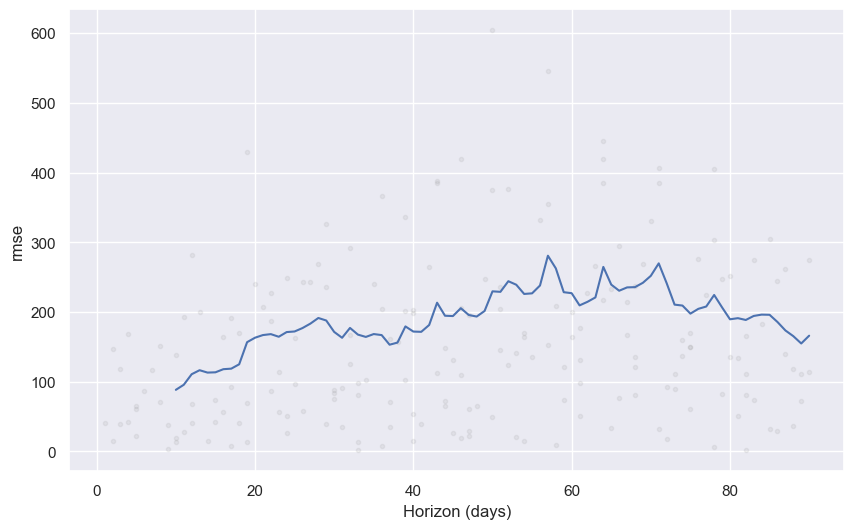

In [46]:
plot_cross_validation_metric(eval_df, metric = 'rmse');

### Automate the model fitting and evaluation (Pour prophet)

In [47]:
routes = (traffic_df
.drop_duplicates(subset= ['home_airport', 'paired_airport'] )
[["home_airport", "paired_airport"]].to_dict(orient= 'rows')
)

/var/folders/q2/tks8t2v53c95y3jqch98mqrc0000gn/T/ipykernel_3326/2408516884.py:1: FutureWarning:

Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.



In [51]:
# %%capture
# output = do_some_verbose_things(args)

In [53]:
routes = (traffic_df
.drop_duplicates(subset= ['home_airport', 'paired_airport'] )
[["home_airport", "paired_airport"]].to_dict(orient= 'rows')
)
models = dict()
performances = dict()
for route in routes[:2]:
    print(route)
    home = route['home_airport']
    paired = route['paired_airport']
    #build route traffic dataFrame
    _df = generate_route_df(traffic_df, home, paired)
    # Create a model
    _model = Prophet()
    #fit 
    _model.fit(_df.rename(columns={'date': 'ds', 'pax_total': 'y'}))
    # and evaluation the model
    _cv_df = cross_validation(_model, horizon= '30 days')
    _perf_df = performance_metrics(_cv_df, rolling_window= 1)
    #save the model to a dictionary
    models[(route['home_airport'], route['paired_airport'])] = _model
    performances[(route['home_airport'], route['paired_airport'])] = _perf_df['rmse'].values[0]


/var/folders/q2/tks8t2v53c95y3jqch98mqrc0000gn/T/ipykernel_3326/1288369371.py:1: FutureWarning:

Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.



{'home_airport': 'LGW', 'paired_airport': 'BCN'}


  0%|          | 0/147 [00:00<?, ?it/s]

{'home_airport': 'LGW', 'paired_airport': 'AMS'}


  0%|          | 0/137 [00:00<?, ?it/s]

In [54]:
routes = (traffic_df
.drop_duplicates(subset= ['home_airport', 'paired_airport'] )
[["home_airport", "paired_airport"]].to_dict(orient= 'rows')
)
models = dict()
performances = dict()
for route in routes:
    print(route)
    home = route['home_airport']
    paired = route['paired_airport']
    #build route traffic dataFrame
    _df = generate_route_df(traffic_df, home, paired)
    # Create a model
    _model = Prophet()
    #fit 
    _model.fit(_df.rename(columns={'date': 'ds', 'pax_total': 'y'}))
    # and evaluation the model
    _cv_df = cross_validation(_model, horizon= '30 days', parallel = "processes")
    _perf_df = performance_metrics(_cv_df, rolling_window= 1)
    #save the model to a dictionary
    models[(route['home_airport'], route['paired_airport'])] = _model
    performances[(route['home_airport'], route['paired_airport'])] = _perf_df['rmse'].values[0]

/var/folders/q2/tks8t2v53c95y3jqch98mqrc0000gn/T/ipykernel_3326/1170065830.py:1: FutureWarning:

Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.



{'home_airport': 'LGW', 'paired_airport': 'BCN'}


21:30:56 - cmdstanpy - INFO - Chain [1] start processing
21:30:56 - cmdstanpy - INFO - Chain [1] done processing
21:30:56 - cmdstanpy - INFO - Chain [1] start processing
21:30:56 - cmdstanpy - INFO - Chain [1] start processing
21:30:56 - cmdstanpy - INFO - Chain [1] start processing
21:30:56 - cmdstanpy - INFO - Chain [1] done processing
21:30:56 - cmdstanpy - INFO - Chain [1] done processing
21:30:56 - cmdstanpy - INFO - Chain [1] start processing
21:30:56 - cmdstanpy - INFO - Chain [1] start processing
21:30:56 - cmdstanpy - INFO - Chain [1] done processing
21:30:56 - cmdstanpy - INFO - Chain [1] start processing
21:30:56 - cmdstanpy - INFO - Chain [1] start processing
21:30:56 - cmdstanpy - INFO - Chain [1] done processing
21:30:56 - cmdstanpy - INFO - Chain [1] done processing
21:30:56 - cmdstanpy - INFO - Chain [1] start processing
21:30:56 - cmdstanpy - INFO - Chain [1] done processing
21:30:56 - cmdstanpy - INFO - Chain [1] done processing
21:30:56 - cmdstanpy - INFO - Chain [1]

{'home_airport': 'LGW', 'paired_airport': 'AMS'}


21:31:08 - cmdstanpy - INFO - Chain [1] start processing
21:31:08 - cmdstanpy - INFO - Chain [1] start processing
21:31:08 - cmdstanpy - INFO - Chain [1] start processing
21:31:08 - cmdstanpy - INFO - Chain [1] done processing
21:31:08 - cmdstanpy - INFO - Chain [1] start processing
21:31:08 - cmdstanpy - INFO - Chain [1] start processing
21:31:08 - cmdstanpy - INFO - Chain [1] done processing
21:31:08 - cmdstanpy - INFO - Chain [1] done processing
21:31:08 - cmdstanpy - INFO - Chain [1] start processing
21:31:08 - cmdstanpy - INFO - Chain [1] done processing
21:31:08 - cmdstanpy - INFO - Chain [1] done processing
21:31:08 - cmdstanpy - INFO - Chain [1] done processing
21:31:08 - cmdstanpy - INFO - Chain [1] start processing
21:31:08 - cmdstanpy - INFO - Chain [1] start processing
21:31:08 - cmdstanpy - INFO - Chain [1] start processing
21:31:08 - cmdstanpy - INFO - Chain [1] start processing
21:31:08 - cmdstanpy - INFO - Chain [1] done processing
21:31:08 - cmdstanpy - INFO - Chain [1

{'home_airport': 'LIS', 'paired_airport': 'ORY'}


21:31:19 - cmdstanpy - INFO - Chain [1] start processing
21:31:19 - cmdstanpy - INFO - Chain [1] start processing
21:31:19 - cmdstanpy - INFO - Chain [1] done processing
21:31:19 - cmdstanpy - INFO - Chain [1] done processing
21:31:19 - cmdstanpy - INFO - Chain [1] start processing
21:31:19 - cmdstanpy - INFO - Chain [1] start processing
21:31:19 - cmdstanpy - INFO - Chain [1] start processing
21:31:19 - cmdstanpy - INFO - Chain [1] done processing
21:31:19 - cmdstanpy - INFO - Chain [1] start processing
21:31:19 - cmdstanpy - INFO - Chain [1] start processing
21:31:19 - cmdstanpy - INFO - Chain [1] done processing
21:31:19 - cmdstanpy - INFO - Chain [1] start processing
21:31:20 - cmdstanpy - INFO - Chain [1] done processing
21:31:20 - cmdstanpy - INFO - Chain [1] start processing
21:31:20 - cmdstanpy - INFO - Chain [1] done processing
21:31:20 - cmdstanpy - INFO - Chain [1] done processing
21:31:20 - cmdstanpy - INFO - Chain [1] start processing
21:31:20 - cmdstanpy - INFO - Chain [1

{'home_airport': 'LIS', 'paired_airport': 'OPO'}


21:31:34 - cmdstanpy - INFO - Chain [1] start processing
21:31:34 - cmdstanpy - INFO - Chain [1] start processing
21:31:34 - cmdstanpy - INFO - Chain [1] start processing
21:31:34 - cmdstanpy - INFO - Chain [1] start processing
21:31:34 - cmdstanpy - INFO - Chain [1] done processing
21:31:34 - cmdstanpy - INFO - Chain [1] done processing
21:31:34 - cmdstanpy - INFO - Chain [1] done processing
21:31:34 - cmdstanpy - INFO - Chain [1] start processing
21:31:34 - cmdstanpy - INFO - Chain [1] done processing
21:31:34 - cmdstanpy - INFO - Chain [1] start processing
21:31:34 - cmdstanpy - INFO - Chain [1] done processing
21:31:34 - cmdstanpy - INFO - Chain [1] done processing
21:31:34 - cmdstanpy - INFO - Chain [1] start processing
21:31:34 - cmdstanpy - INFO - Chain [1] start processing
21:31:34 - cmdstanpy - INFO - Chain [1] start processing
21:31:34 - cmdstanpy - INFO - Chain [1] start processing
21:31:34 - cmdstanpy - INFO - Chain [1] start processing
21:31:34 - cmdstanpy - INFO - Chain [

{'home_airport': 'SSA', 'paired_airport': 'GRU'}


21:31:53 - cmdstanpy - INFO - Chain [1] start processing
21:31:53 - cmdstanpy - INFO - Chain [1] start processing
21:31:53 - cmdstanpy - INFO - Chain [1] start processing
21:31:53 - cmdstanpy - INFO - Chain [1] start processing
21:31:53 - cmdstanpy - INFO - Chain [1] done processing
21:31:53 - cmdstanpy - INFO - Chain [1] done processing
21:31:53 - cmdstanpy - INFO - Chain [1] start processing
21:31:53 - cmdstanpy - INFO - Chain [1] done processing
21:31:53 - cmdstanpy - INFO - Chain [1] done processing
21:31:53 - cmdstanpy - INFO - Chain [1] start processing
21:31:53 - cmdstanpy - INFO - Chain [1] done processing
21:31:53 - cmdstanpy - INFO - Chain [1] start processing
21:31:53 - cmdstanpy - INFO - Chain [1] done processing
21:31:53 - cmdstanpy - INFO - Chain [1] start processing
21:31:53 - cmdstanpy - INFO - Chain [1] start processing
21:31:53 - cmdstanpy - INFO - Chain [1] start processing
21:31:53 - cmdstanpy - INFO - Chain [1] start processing
21:31:53 - cmdstanpy - INFO - Chain [

{'home_airport': 'NTE', 'paired_airport': 'FUE'}


21:32:00 - cmdstanpy - INFO - Chain [1] start processing
21:32:00 - cmdstanpy - INFO - Chain [1] start processing
21:32:00 - cmdstanpy - INFO - Chain [1] start processing
21:32:00 - cmdstanpy - INFO - Chain [1] start processing
21:32:00 - cmdstanpy - INFO - Chain [1] start processing
21:32:00 - cmdstanpy - INFO - Chain [1] start processing
21:32:00 - cmdstanpy - INFO - Chain [1] start processing
21:32:00 - cmdstanpy - INFO - Chain [1] done processing
21:32:00 - cmdstanpy - INFO - Chain [1] done processing
21:32:00 - cmdstanpy - INFO - Chain [1] start processing
21:32:00 - cmdstanpy - INFO - Chain [1] start processing
21:32:01 - cmdstanpy - INFO - Chain [1] done processing
21:32:01 - cmdstanpy - INFO - Chain [1] start processing
21:32:01 - cmdstanpy - INFO - Chain [1] done processing
21:32:01 - cmdstanpy - INFO - Chain [1] done processing
21:32:01 - cmdstanpy - INFO - Chain [1] done processing
21:32:01 - cmdstanpy - INFO - Chain [1] start processing
21:32:01 - cmdstanpy - INFO - Chain [

{'home_airport': 'LYS', 'paired_airport': 'PIS'}


21:32:04 - cmdstanpy - INFO - Chain [1] start processing
21:32:04 - cmdstanpy - INFO - Chain [1] start processing
21:32:04 - cmdstanpy - INFO - Chain [1] start processing
21:32:04 - cmdstanpy - INFO - Chain [1] start processing
21:32:04 - cmdstanpy - INFO - Chain [1] start processing
21:32:05 - cmdstanpy - INFO - Chain [1] start processing
21:32:05 - cmdstanpy - INFO - Chain [1] start processing
21:32:05 - cmdstanpy - INFO - Chain [1] start processing
21:32:05 - cmdstanpy - INFO - Chain [1] done processing
21:32:05 - cmdstanpy - INFO - Chain [1] start processing
21:32:07 - cmdstanpy - INFO - Chain [1] done processing
21:32:07 - cmdstanpy - INFO - Chain [1] done processing
21:32:07 - cmdstanpy - INFO - Chain [1] start processing
21:32:07 - cmdstanpy - INFO - Chain [1] done processing
21:32:07 - cmdstanpy - INFO - Chain [1] start processing
21:32:07 - cmdstanpy - INFO - Chain [1] start processing
21:32:07 - cmdstanpy - INFO - Chain [1] done processing
21:32:07 - cmdstanpy - INFO - Chain 

{'home_airport': 'PNH', 'paired_airport': 'NGB'}


21:32:30 - cmdstanpy - INFO - Chain [1] start processing
21:32:30 - cmdstanpy - INFO - Chain [1] start processing
21:32:30 - cmdstanpy - INFO - Chain [1] start processing
21:32:30 - cmdstanpy - INFO - Chain [1] start processing
21:32:30 - cmdstanpy - INFO - Chain [1] start processing
21:32:30 - cmdstanpy - INFO - Chain [1] done processing
21:32:30 - cmdstanpy - INFO - Chain [1] done processing
21:32:30 - cmdstanpy - INFO - Chain [1] done processing
21:32:31 - cmdstanpy - INFO - Chain [1] start processing
21:32:31 - cmdstanpy - INFO - Chain [1] start processing
21:32:31 - cmdstanpy - INFO - Chain [1] start processing
21:32:31 - cmdstanpy - INFO - Chain [1] start processing
21:32:31 - cmdstanpy - INFO - Chain [1] start processing
21:32:31 - cmdstanpy - INFO - Chain [1] done processing
21:32:31 - cmdstanpy - INFO - Chain [1] done processing
21:32:31 - cmdstanpy - INFO - Chain [1] start processing
21:32:31 - cmdstanpy - INFO - Chain [1] start processing
21:32:31 - cmdstanpy - INFO - Chain 

{'home_airport': 'POP', 'paired_airport': 'JFK'}


21:32:40 - cmdstanpy - INFO - Chain [1] start processing
21:32:40 - cmdstanpy - INFO - Chain [1] start processing
21:32:40 - cmdstanpy - INFO - Chain [1] start processing
21:32:40 - cmdstanpy - INFO - Chain [1] start processing
21:32:40 - cmdstanpy - INFO - Chain [1] done processing
21:32:40 - cmdstanpy - INFO - Chain [1] done processing
21:32:40 - cmdstanpy - INFO - Chain [1] done processing
21:32:40 - cmdstanpy - INFO - Chain [1] done processing
21:32:40 - cmdstanpy - INFO - Chain [1] start processing
21:32:40 - cmdstanpy - INFO - Chain [1] start processing
21:32:40 - cmdstanpy - INFO - Chain [1] start processing
21:32:40 - cmdstanpy - INFO - Chain [1] start processing
21:32:40 - cmdstanpy - INFO - Chain [1] start processing
21:32:40 - cmdstanpy - INFO - Chain [1] done processing
21:32:40 - cmdstanpy - INFO - Chain [1] start processing
21:32:40 - cmdstanpy - INFO - Chain [1] done processing
21:32:40 - cmdstanpy - INFO - Chain [1] start processing
21:32:40 - cmdstanpy - INFO - Chain [

{'home_airport': 'SCL', 'paired_airport': 'LHR'}


21:32:47 - cmdstanpy - INFO - Chain [1] start processing
21:32:47 - cmdstanpy - INFO - Chain [1] done processing
21:32:47 - cmdstanpy - INFO - Chain [1] start processing
21:32:47 - cmdstanpy - INFO - Chain [1] start processing
21:32:47 - cmdstanpy - INFO - Chain [1] start processing
21:32:47 - cmdstanpy - INFO - Chain [1] done processing
21:32:47 - cmdstanpy - INFO - Chain [1] done processing
21:32:47 - cmdstanpy - INFO - Chain [1] start processing
21:32:47 - cmdstanpy - INFO - Chain [1] done processing
21:32:47 - cmdstanpy - INFO - Chain [1] start processing
21:32:47 - cmdstanpy - INFO - Chain [1] start processing
21:32:47 - cmdstanpy - INFO - Chain [1] done processing
21:32:47 - cmdstanpy - INFO - Chain [1] done processing
21:32:47 - cmdstanpy - INFO - Chain [1] start processing
21:32:47 - cmdstanpy - INFO - Chain [1] start processing
21:32:48 - cmdstanpy - INFO - Chain [1] done processing
21:32:48 - cmdstanpy - INFO - Chain [1] start processing
21:32:48 - cmdstanpy - INFO - Chain [1

In [55]:
models

{('LGW', 'BCN'): <prophet.forecaster.Prophet at 0x7fc280a7cca0>,
 ('LGW', 'AMS'): <prophet.forecaster.Prophet at 0x7fc2b663f880>,
 ('LIS', 'ORY'): <prophet.forecaster.Prophet at 0x7fc2a78b91f0>,
 ('LIS', 'OPO'): <prophet.forecaster.Prophet at 0x7fc280219dc0>,
 ('SSA', 'GRU'): <prophet.forecaster.Prophet at 0x7fc280219520>,
 ('NTE', 'FUE'): <prophet.forecaster.Prophet at 0x7fc280a7b5e0>,
 ('LYS', 'PIS'): <prophet.forecaster.Prophet at 0x7fc288012ac0>,
 ('PNH', 'NGB'): <prophet.forecaster.Prophet at 0x7fc280219880>,
 ('POP', 'JFK'): <prophet.forecaster.Prophet at 0x7fc28880c370>,
 ('SCL', 'LHR'): <prophet.forecaster.Prophet at 0x7fc2d445ee50>}

In [56]:
performances

{('LGW', 'BCN'): 1019.1954097881318,
 ('LGW', 'AMS'): 747.826798529831,
 ('LIS', 'ORY'): 718.4211284613352,
 ('LIS', 'OPO'): 484.53754253063454,
 ('SSA', 'GRU'): 1384.5472814195223,
 ('NTE', 'FUE'): 165.81012310104074,
 ('LYS', 'PIS'): 519.4399056992781,
 ('PNH', 'NGB'): 1827.209890884584,
 ('POP', 'JFK'): 63.417292397609565,
 ('SCL', 'LHR'): 104.1813066505356}

In [57]:

for model in models:
    _filename = 'route_model_prophet_{home}_{paired}.json'.format(home = model[0], paired = model[1])
    with open("_filename", "w") as f:
        f.write(model_to_json(models[model]))

In [58]:
reload_models = dict()
for route in routes:
    _filename = 'route_model_prophet_{home}_{paired}.json'.format(home = route['home_airport'], paired = route["paired_airport"])
    with open("_filename", 'r') as f:
        reload_models[(route['home_airport'], route["paired_airport"])] = model_from_json(f.read())

/opt/anaconda3/envs/airtraffic/lib/python3.9/site-packages/prophet/serialize.py:160: FutureWarning:

The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')

/opt/anaconda3/envs/airtraffic/lib/python3.9/site-packages/prophet/serialize.py:160: FutureWarning:

The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')

/opt/anaconda3/envs/airtraffic/lib/python3.9/site-packages/prophet/serialize.py:160: FutureWarning:

The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC tim

In [ ]:
reload_models

In [59]:
reload_models = dict()
for model in models:
    _filename = 'route_model_prophet_{home}_{paired}.json'.format(home = model[0], paired = model[1])
    dump(models[model], _filename)
    

In [ ]:
for model in models:
    _filename = 'route_model_prophet_{home}_{paired}.json'.format(home = model[0], paired = model[1])
    reload_models[(route['home_airport'], route["paired_airport"])] =  load(_filename)

### Nixtla 

In [ ]:
models = [
    lgb.LGBMRegressor(),
    xgb.XGBRegressor(),
    RandomForestRegressor(random_state=0),
]



@njit
def rolling_mean_28(x):
    return rolling_mean(x, window_size=28)


fcst = MLForecast(
    models=models,
    freq='D',
    lags=[7, 14, 21, 28],
    lag_transforms={
        1: [expanding_mean],
        7: [rolling_mean_28]
    },
    date_features=['dayofweek'],
    differences=[1],
)


In [ ]:
nixtla_model = fcst.fit(generate_route_df(traffic_df, 'NTE', 'FUE').drop(columns = ['paired_airport']),id_col = 'home_airport', time_col= 'date', target_col= 'pax_total')

In [ ]:
predict_df = nixtla_model.predict(14)
predict_df

In [ ]:
(pd.concat([generate_route_df(traffic_df, 'NTE', 'FUE').drop(columns = ['paired_airport']), nixtla_model.predict(7 * 10)])
.set_index('date')
).plot(figsize= (15,7))
;

In [ ]:
draw_ts_multiple((pd.concat([generate_route_df(traffic_df, 'LGW', 'AMS').drop(columns = ['paired_airport']), nixtla_model.predict(7 * 10)])),
                v1 = 'pax_total', v2 = 'LGBMRegressor');

In [ ]:
crossvalidation_df = fcst.cross_validation(
    data=generate_route_df(traffic_df, "LGW", "AMS").drop(columns=['paired_airport']),
    window_size=90,
    n_windows=5,
    id_col='home_airport',
    time_col='date',
    target_col='pax_total'
)

In [ ]:
import numpy as np

def mse(y, y_hat):
  delta_y = np.square(y - y_hat)
  return np.nanmean(delta_y)

def rmse(y, y_hat):
  delta_y = np.square(y - y_hat)
  return np.sqrt(mse(y, y_hat))

cv_rmse = crossvalidation_df.groupby(['home_airport', 'cutoff']).apply(lambda df: rmse(df['pax_total'], df['LGBMRegressor'])).mean()
print("RMSE using cross-validation: ", cv_rmse)

cv_rmse = crossvalidation_df.groupby(['home_airport', 'cutoff']).apply(lambda df: rmse(df['pax_total'], df['RandomForestRegressor'])).mean()
print("RMSE using cross-validation: ", cv_rmse)

cv_rmse = crossvalidation_df.groupby(['home_airport', 'cutoff']).apply(lambda df: rmse(df['pax_total'], df['XGBRegressor'])).mean()
print("RMSE using cross-validation: ", cv_rmse)

cv_rmse = (crossvalidation_df
           .assign(Ensemble=lambda _df: _df[['LGBMRegressor', 'RandomForestRegressor', 'XGBRegressor']].mean(axis=1))
           .groupby(['home_airport', 'cutoff']).apply(lambda df: rmse(df['pax_total'], df['Ensemble'])).mean())
print("Ensemble RMSE using cross-validation: ", cv_rmse)

### Model Neural forecast

In [ ]:


# from neuralforecast import NeuralForecast
# from neuralforecast.models import NBEATS, NHITS

# horizon = 90
# models = [NBEATS(input_size=2 * horizon, h=horizon, max_epochs=50),
#           NHITS(input_size=2 * horizon, h=horizon, max_epochs=50)]

# nforecast = NeuralForecast(models=models, freq='D')
# nforecast.fit(df=generate_route_df(traffic_df, "LGW", "AMS").drop(columns=['paired_airport']).rename(columns={'home_airport': 'unique_id',
#                                                                                                       'date': 'ds',
#                                                                                                       'pax_total': 'y'}))